# Advanced Housing Dataset Exploration

1.  Introduction
2.  Exploring the Data
3.  Plotting the Data
4.  Training the Model

Eh, ToC needs work!!

# Introduction


Hello. My name is Evan Freeman. I'm currently just messing around with pandas, matplotlib, and seaborn, and scikit-learn to improve my data analysis and visualization skills. I know this analysis is rather simplistic and makes some arbitrary selections. But I'm primarily focusing on my competence with these libraries, not so much on the optimal data science procedures.

Here we'll be considering the Ames Housing dataset, which is like the Boston Housing dataset, but better!!

## Procedure

1. Split Validation Data (Test data is already seperate, Kaggle will test my model on that data)
  1. 80 / 20 Split
  2. k-fold cross validation
    1. I'll have to rerun the whole pipeline for each fold
    2. I've read that 5 or 10 folds are good. Not sure why exactly those numbers.
2. Visually investigate the data
3.  Feature Generations 
  1. Categorical Parings
  2. Numerical Transformations 
4.  Feature Selection
  1. Principal Component Analysis???
  2. Univariate
  3. Lasso (L1)
  4. Ridge (L2)
5.  Try different models
  1.  Simple Regression
  2.  Random Forest
  3.  XGBoost
  4.  LightGBM
  5.  Neural Net (lol wut)
6.  Hyperparameter Tuning (my fav)
7.  Compare them!

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from IPython.display import display
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV as gscv
from sklearn.model_selection import RandomizedSearchCV as rscv

# pd.options.display.max_columns = None
pd.options.display.max_rows = 56

housing = pd.read_csv('D:/code/Data/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('D:/code/Data/house-prices-advanced-regression-techniques/test.csv')

Note: The test data has already been split for us by Kaggle, but we MUST split off validation data (or do k-fold) as well!!! Otherwise we will overfit.  

Let's split off 20% for validation.  

Later, we'll try with k-fold validation, which should produce better results.  

It is worth pointing out that, once we've trained and validated our model, chosing the best type of model, the best features, the best hyperparameters, we should go back and train it from scratch on the entire dataset (train + valid). If we don't, we're just hamstringing our model by not using all the available data.

Also, we'll create a pipeline for all these steps. For now, we're just exploring.

In [2]:
# Train Valid Split, 80 / 20

train, valid = train_test_split(housing, test_size = .2)

# Also, we're going to need the test ids for submission, so let's grab those

test_id = test['Id']

# Plotting the Data

Before we start processing the data, let's visualize the data and see if we can pick out any interesting information that way.

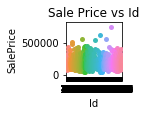

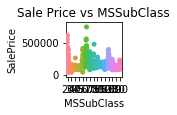

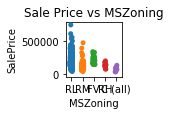

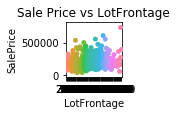

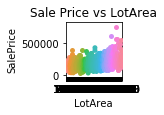

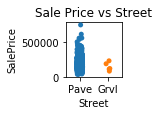

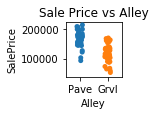

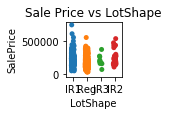

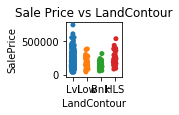

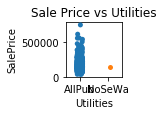

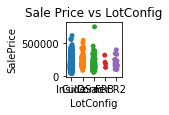

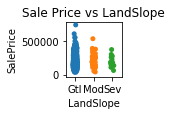

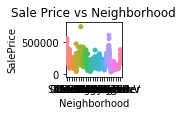

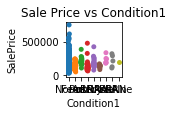

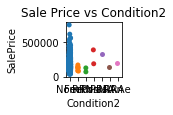

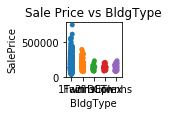

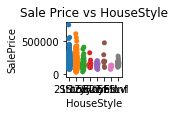

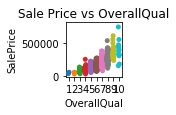

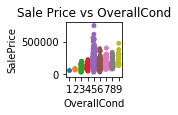

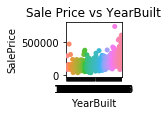

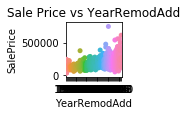

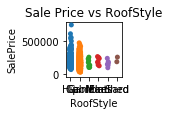

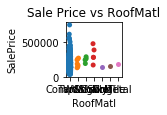

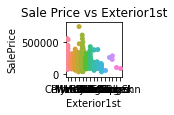

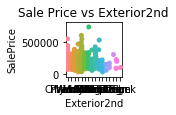

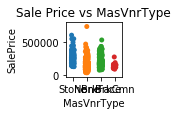

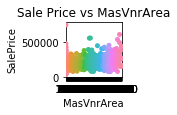

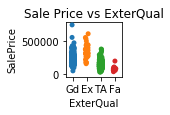

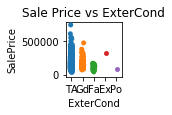

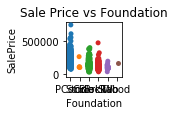

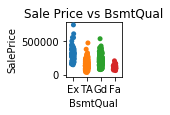

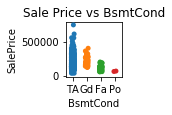

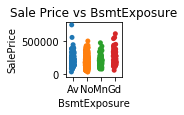

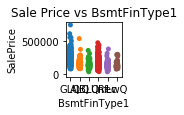

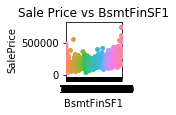

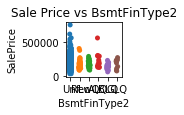

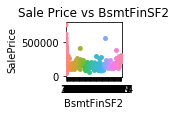

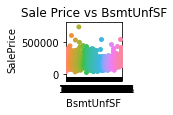

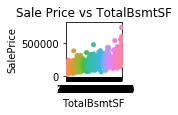

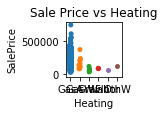

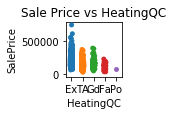

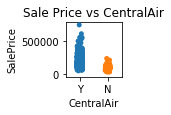

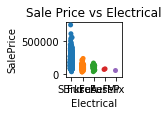

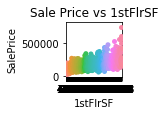

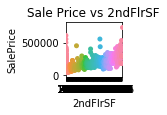

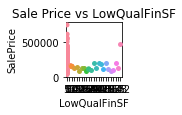

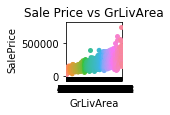

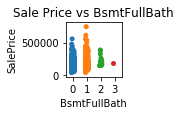

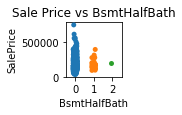

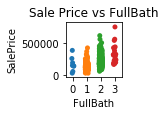

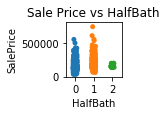

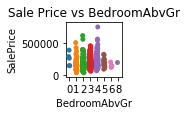

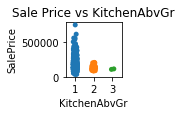

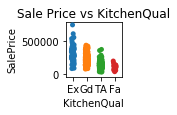

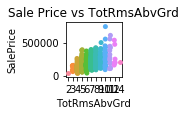

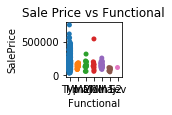

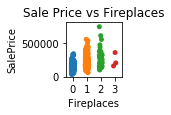

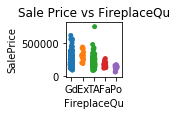

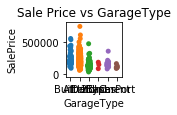

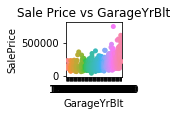

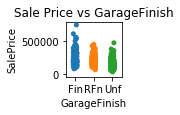

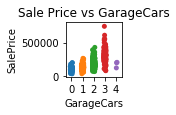

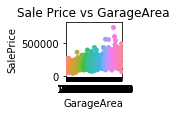

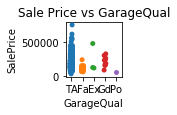

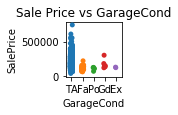

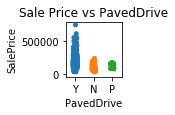

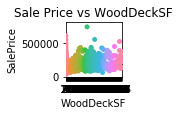

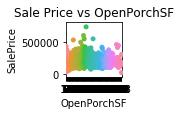

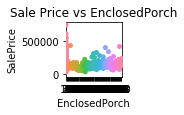

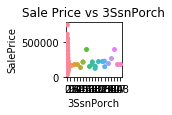

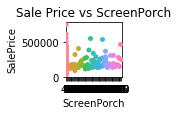

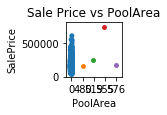

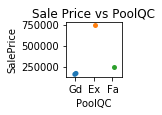

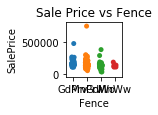

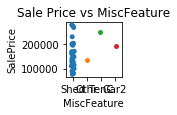

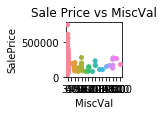

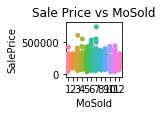

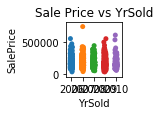

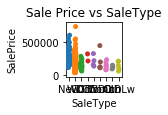

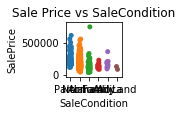

In [3]:
# Scatter Plots for all features vs target

for feature in train.columns:
    if feature != 'SalePrice':
        plt.figure(figsize = (1, 1))
        sns.stripplot(x = feature, y = 'SalePrice', hue = None, data = train)
        plt.title(f'Sale Price vs {feature}')
        plt.show()

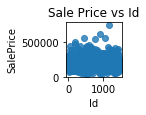

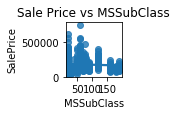

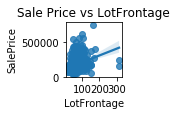

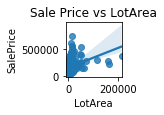

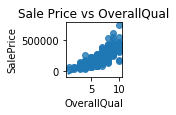

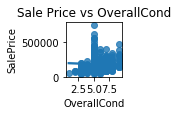

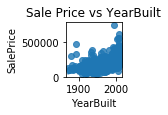

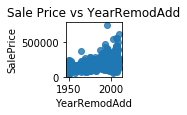

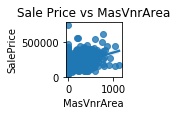

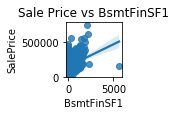

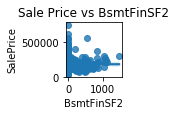

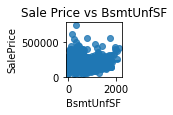

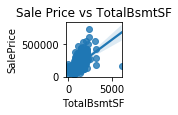

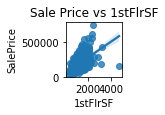

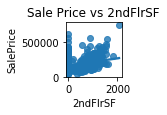

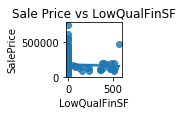

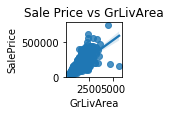

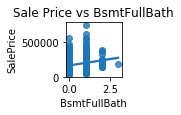

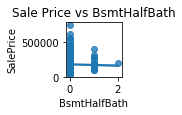

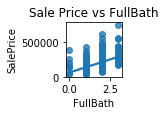

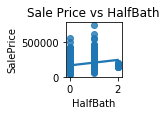

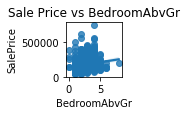

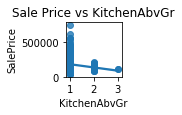

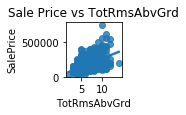

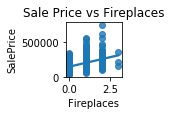

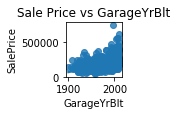

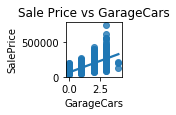

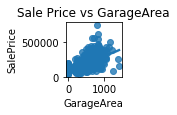

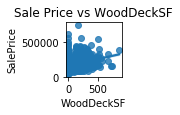

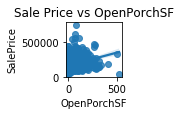

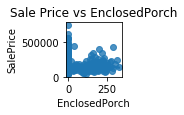

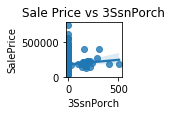

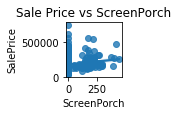

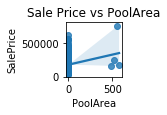

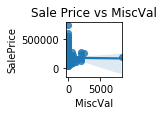

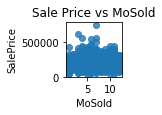

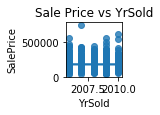

In [4]:
# Let's try to do regression only for numerical features vs target

count = 0

for feature in train.columns:
    if is_numeric_dtype(train[feature]) and feature != 'SalePrice':
        count += 1
        plt.figure(figsize = (1, 1))
        plt.title(f'Sale Price vs {feature}')
        sns.regplot(x = feature, y = 'SalePrice', data = train)
        plt.show()

Some initial thoughts based on these graphs:
1. Many of these features do not seem correlated with our target. However, we must not forget that there may be interactions between these seemingly irrelevant features which ARE correlated with our target.

# Preprocessing the Data

Before we start selecting and training models, we have to preprocess our data. This includes things like dealing with missing values, encoding categorical features, and scaling the data to a normal range.

In [5]:
display(train)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1046,1047,60,RL,85.0,16056,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,New,Partial,556581
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
550,551,120,RL,53.0,4043,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2008,COD,Abnorml,140000
1296,1297,20,RL,80.0,8700,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,12,2008,WD,Normal,155000
1269,1270,50,RL,78.0,11344,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,7,2007,WD,Normal,144000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,324,20,RM,49.0,5820,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,126175
1047,1048,20,RL,57.0,9245,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,145000
1247,1248,80,RL,NaN,12328,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,169900
374,375,60,RL,65.0,8200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2007,WD,Normal,219500


In [6]:
display(train.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1168.000000,1168.000000,954.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1161.000000,1168.000000,...,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,743.690925,56.904966,69.550314,10587.364726,6.060788,5.563356,1971.010274,1984.650685,98.361757,433.379281,...,91.921233,45.502568,22.826199,3.634418,14.880137,1.823630,32.517123,6.386130,2007.815068,178086.728596
std,418.719001,42.341862,24.603297,10918.184342,1.376347,1.108243,30.324691,20.662039,168.693044,461.582664,...,124.737231,63.796162,60.697515,30.208004,55.115204,31.195512,297.321663,2.698639,1.329919,75504.268049
min,1.000000,20.000000,21.000000,1477.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,388.750000,20.000000,59.000000,7402.000000,5.000000,5.000000,1954.000000,1966.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000
50%,746.000000,50.000000,68.000000,9351.500000,6.000000,5.000000,1972.000000,1993.000000,0.000000,370.000000,...,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162000.000000
75%,1095.250000,70.000000,80.000000,11588.000000,7.000000,6.000000,2000.000000,2004.000000,160.000000,698.250000,...,168.000000,66.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,207500.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2009.000000,2010.000000,1129.000000,5644.000000,...,857.000000,523.000000,330.000000,508.000000,440.000000,576.000000,8300.000000,12.000000,2010.000000,745000.000000


## Dealing with missing values

We have a number of choices for dealing with missing values. Let's begin by dropping features which are missing a lot of data (15% or more).

We have to drop from valid, train, and test sets. ONLY USE THE INFO FROM THE TRAIN TO MAKE THE DROPS.

In [8]:
train_null = train.isnull()
train_null_sum = train_null[train_null.columns[train_null.sum() > len(train) * .15]].sum()
display(train_null_sum)
print('')
display(train.columns[train.isnull().sum() > len(train) * .15])
print('')
display(train[train.columns[train.isnull().sum() > len(train) * .15]])

LotFrontage     214
Alley          1094
FireplaceQu     562
PoolQC         1164
Fence           951
MiscFeature    1127
dtype: int64

Index(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

,LotFrontage,Alley,FireplaceQu,PoolQC,Fence,MiscFeature
1046,85.0,NaN,Gd,NaN,NaN,NaN
1457,66.0,NaN,Gd,NaN,GdPrv,Shed
550,53.0,NaN,NaN,NaN,NaN,NaN
1296,80.0,NaN,NaN,NaN,MnPrv,NaN
1269,78.0,NaN,NaN,NaN,GdWo,NaN
...,...,...,...,...,...,...
323,49.0,NaN,NaN,NaN,NaN,NaN
1047,57.0,NaN,NaN,NaN,NaN,NaN
1247,NaN,NaN,NaN,NaN,NaN,NaN
374,65.0,NaN,Gd,NaN,NaN,NaN


All of these features seem peripheral, and not useful to our model, so let's just drop them.

In [9]:
columns_to_drop = train.loc[:, train.isnull().sum() > len(train) * .15].columns
display(columns_to_drop)
train.drop(columns_to_drop, inplace = True, axis = 1)
valid.drop(columns_to_drop, inplace = True, axis = 1)
test.drop(columns_to_drop, inplace = True, axis = 1)
display(train)
display(valid)
display(test)

Index(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1046,1047,60,RL,16056,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,7,2006,New,Partial,556581
1457,1458,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,266500
550,551,120,RL,4043,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,200,0,0,10,2008,COD,Abnorml,140000
1296,1297,20,RL,8700,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,123,0,0,0,0,12,2008,WD,Normal,155000
1269,1270,50,RL,11344,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,7,2007,WD,Normal,144000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,324,20,RM,5820,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,7,2006,WD,Normal,126175
1047,1048,20,RL,9245,Pave,IR2,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,145000
1247,1248,80,RL,12328,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,5,2010,WD,Normal,169900
374,375,60,RL,8200,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,7,2007,WD,Normal,219500


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1294,1295,20,RL,8172,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,4,2006,WD,Normal,115000
1194,1195,60,RL,9364,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,3,2010,WD,Normal,158000
499,500,20,RL,7535,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,480,6,2007,WD,Normal,120000
372,373,120,RL,7175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,90,0,0,2,2010,WD,Normal,125000
30,31,70,C (all),8500,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,172,0,0,0,0,7,2008,WD,Normal,40000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,349,160,RL,2448,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2008,WD,Normal,154000
1051,1052,20,RL,11175,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,10,2007,New,Partial,200141
599,600,160,RM,1950,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,7,2008,COD,Normal,151000
124,125,20,RL,17043,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,0,0,0,0,0,1,2009,WD,Normal,181000


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,120,0,0,6,2010,WD,Normal
1,1462,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,36,0,0,0,0,12500,6,2010,WD,Normal
2,1463,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,34,0,0,0,0,0,3,2010,WD,Normal
3,1464,60,RL,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,36,0,0,0,0,0,6,2010,WD,Normal
4,1465,120,RL,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,...,82,0,0,144,0,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,6,2006,WD,Normal
1455,2916,160,RM,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,24,0,0,0,0,0,4,2006,WD,Abnorml
1456,2917,20,RL,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,9,2006,WD,Abnorml
1457,2918,85,RL,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,32,0,0,0,0,700,7,2006,WD,Normal


That was a good start, but we still have a lot of missing values throughout our data. Let's do simple imputting for the rest, with median for numerical features and mode for categorical features. sklearn has a great function for this built in.

In [10]:
num_columns = train.select_dtypes(exclude=['object']).columns
cat_columns = train.select_dtypes(include=['object']).columns

display(num_columns)
display(cat_columns)

Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [11]:
# Impute Categorical Values
train.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(train.loc[:, cat_columns])
valid.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(valid.loc[:, cat_columns])
test.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(test.loc[:, cat_columns])

# Impute Numerical Values
train.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(train.loc[:, num_columns])
valid.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(valid.loc[:, num_columns])
test.loc[:, num_columns.drop('SalePrice')] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(test.loc[:, num_columns.drop('SalePrice')])

C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

## Categorical Features

Let's look at the Categorical Features and decide what to do with them.

In [12]:
train_cat = train.select_dtypes(exclude = [np.number])
display(train_cat)

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
1046,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,...,SBrkr,Ex,Typ,BuiltIn,Fin,TA,TA,Y,New,Partial
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
550,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NPkVill,Norm,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,COD,Abnorml
1296,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1269,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,...,FuseA,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,...,SBrkr,TA,Typ,Attchd,Unf,Fa,TA,Y,WD,Normal
1047,RL,Pave,IR2,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,TA,Typ,Detchd,Unf,TA,TA,Y,WD,Normal
1247,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,...,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
374,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,BuiltIn,Fin,TA,TA,Y,WD,Normal


Many of these variable seem ripe for an ordinal encoding, where we turn each entry into a number, like 0, 1, 2, 3... Note that this is a good idea for categorical features which have some inherent order. But if the feature is not ordered in some sense, then ordinal encoding will confuse the algorithm into believing* there is some inherent order. Certianly there is room for debate on just how ordinal some of these features are.  

*No, machines can't think, I'm just anthropomorphising.

Here's a list of features that seem ordinal to me:  
1. LotShape: How regular or irregular the property is shaped
2. Utilities: Which utilities are available, as a chain of sets, which gives order.
3. LandSlope: How sloped the property is
4. ExterQual: Evaluates the quality of the material on the exterior 
5. ExterCond: Evaluates the present condition of the material on the exterior
6. BsmtQual: Evaluates the height of the basement
7. BsmtCond: Evaluates the general condition of the basement
8. BsmtExposure: Refers to walkout or garden level walls
9. BsmtFinType1: Rating of basement finished area
10. BsmtFinType2: Rating of basement finished area (if multiple types)
11. HeatingQC: Heating quality and condition
12. CentralAir: Central air conditioning
13. Electrical: Electrical system
14. KitchenQual: Kitchen quality
15. Functional: Home functionality (Assume typical unless deductions are warranted)
16. FireplaceQu: Fireplace quality. BUT we already dropped this, as it was missing too many values.
17. GarageFinish: Interior finish of the garage
18. GarageQual: Garage quality
19. GarageCond: Garage condition
20. PavedDrive: Paved driveway
21. PoolQC: Pool quality. But, we already dropped this, as it was missing too many values.
22. Fence Quality. BUT, we already dropped this, as it was missing too many values.

While sklearn has a nice OrdinalEncoder built in, it can't know the real world values of these descriptions (e.g. for Garage Finish we should have Finished > Rough Finished > Unfinished > No Garage, though even here there could be debate about whether No Garage is truly lower than the other options, or just incomparable). Therefore, I will have to manually encode all of these...  

Sigh...

In [13]:
# Here are all our maps
# I'm following the convention of giving the worst value 0, and the best the maximum

lotshape_map = {'Reg':3, 'IR1':2, 'IR2':1, 'IR2':0}
utilities_map = {'AllPub':3, 'NoSewr':2, 'NoSeWa':1, 'ELO':0}
landslope_map = {'Gtl':2, 'Mod':1, 'Sev':0}
exterqual_map = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0}
extercond_map = exterqual_map
bsmtqual_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
bsmtcond_map = bsmtqual_map
bsmtexposure_map = {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0}

# BSMTFinType1 is a bit strange, because they throw Rec Room in with all the other assesments. I'll set the two averages equal in value, then scale the rest
bsmtfintype1_map = {'GLQ':5, 'ALQ':4, 'BLQ':3, 'Rec':4, 'LwQ':2, 'Unf':1, 'NA':0}
bsmtfintype2_map = bsmtfintype1_map

heatingqc_map = exterqual_map
centralair_map = {'Y':1, 'N':0}

# Electrical is also weird, as there is a mixed option. I'll just set that to a middle value.
electrical_map = {'SBrkr':3, 'FuseA':2, 'FuseF':1, 'FuseP':0}

kitchenqual_map = exterqual_map
functional_map = {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0}
garagefinish_map = {'Fin':3, 'RFn':2, 'Unf':1, 'NA':0}
garagequal_map = bsmtqual_map
garagecond_map = bsmtqual_map
paveddrive_map = {'Y':2, 'P':1, 'N':0}

# Here is a list of the maps I just made, so we can just iterate through them
ordinal_maps = [lotshape_map, utilities_map, landslope_map, exterqual_map, extercond_map, bsmtqual_map, bsmtcond_map, bsmtexposure_map, bsmtfintype1_map, bsmtfintype2_map, heatingqc_map, centralair_map, electrical_map, kitchenqual_map, functional_map, garagefinish_map, garagequal_map, garagecond_map, paveddrive_map]

# Here's our list of columns to map, so we can just iterate through them

ordinal_features = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive']

In [14]:
for i in range(len(ordinal_maps)):
    train[ordinal_features[i]] = train[ordinal_features[i]].map(ordinal_maps[i])
    valid[ordinal_features[i]] = valid[ordinal_features[i]].map(ordinal_maps[i])
    test[ordinal_features[i]] = test[ordinal_features[i]].map(ordinal_maps[i])

display(train[ordinal_features])
display(valid[ordinal_features])
display(test[ordinal_features])

C:\Users\evant\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\evant\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,LotShape,Utilities,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageFinish,GarageQual,GarageCond,PavedDrive
1046,2.0,3,2,3,2,5,3,3,5,1,4,1,3.0,4,7,3,3,3,2
1457,3.0,3,2,4,3,3,4,1,5,1,4,1,3.0,3,7,2,3,3,2
550,3.0,3,2,2,2,4,3,1,4,1,2,1,3.0,2,7,2,3,3,2
1296,3.0,3,2,2,3,3,3,2,4,1,3,1,3.0,2,7,2,3,3,2
1269,3.0,3,2,2,2,3,3,1,3,1,2,1,2.0,2,7,1,3,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,3.0,3,2,2,3,3,3,1,4,1,4,1,3.0,2,7,1,2,3,2
1047,0.0,3,2,2,2,4,3,1,5,1,4,1,3.0,2,7,1,3,3,2
1247,2.0,3,2,2,2,3,3,3,5,1,2,1,3.0,2,7,1,3,3,2
374,3.0,3,2,3,2,4,3,1,1,1,4,1,3.0,3,7,3,3,3,2


,LotShape,Utilities,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageFinish,GarageQual,GarageCond,PavedDrive
1294,3.0,3,2,2,2,3,3,1,4,1,2,1,3,2,7,1,3,3,0
1194,3.0,3,2,2,2,3,3,1,4,1,2,1,3,2,7,3,3,3,2
499,2.0,3,2,2,2,3,3,1,3,2,1,1,3,2,7,3,3,3,2
372,3.0,3,2,2,2,4,3,1,4,2,2,1,3,2,7,1,3,3,2
30,3.0,3,2,2,1,3,3,1,1,1,2,0,3,2,7,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,3.0,3,2,3,2,4,3,1,5,1,4,1,3,3,7,2,3,3,2
1051,2.0,3,2,3,2,4,3,3,1,1,4,1,3,3,7,3,3,3,2
599,3.0,3,2,2,3,4,3,1,2,5,2,1,3,2,7,3,3,3,2
124,2.0,3,2,2,3,4,2,1,1,1,2,1,3,2,7,1,3,3,2


,LotShape,Utilities,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageFinish,GarageQual,GarageCond,PavedDrive
0,3.0,3,2,2,2,3,3,1,4,2,2,1,3,2,7,1,3,3,2
1,2.0,3,2,2,2,3,3,1,4,1,2,1,3,3,7,1,3,3,2
2,2.0,3,2,2,2,4,3,1,5,1,3,1,3,2,7,3,3,3,2
3,2.0,3,2,2,2,3,3,1,5,1,4,1,3,3,7,3,3,3,2
4,2.0,3,2,3,2,4,3,1,4,1,4,1,3,3,7,2,3,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,3.0,3,2,2,2,3,3,1,1,1,3,1,3,2,7,1,3,3,2
1455,3.0,3,2,2,2,3,3,1,4,1,2,1,3,2,7,1,3,3,2
1456,3.0,3,2,2,2,3,3,1,4,1,4,1,3,2,7,1,3,3,2
1457,3.0,3,2,2,2,4,3,3,5,1,2,1,3,2,7,1,3,3,2


Ok, let's see what categorical features are left to deal with.

In [15]:
train_cat = train.select_dtypes(exclude = [np.number])
display(train_cat)

,MSZoning,Street,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,GarageType,SaleType,SaleCondition
1046,RL,Pave,Lvl,Inside,StoneBr,Norm,Norm,1Fam,2Story,Hip,CompShg,CemntBd,CmentBd,Stone,PConc,GasA,BuiltIn,New,Partial
1457,RL,Pave,Lvl,Inside,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,CemntBd,CmentBd,None,Stone,GasA,Attchd,WD,Normal
550,RL,Pave,Lvl,Inside,NPkVill,Norm,Norm,TwnhsE,1Story,Gable,CompShg,Plywood,Plywood,None,CBlock,GasA,Attchd,COD,Abnorml
1296,RL,Pave,Lvl,Inside,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,BrkFace,CBlock,GasA,Attchd,WD,Normal
1269,RL,Pave,Lvl,Inside,NAmes,Feedr,Norm,1Fam,1.5Fin,Gable,CompShg,MetalSd,MetalSd,BrkFace,CBlock,GasW,Attchd,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,RM,Pave,Lvl,Inside,OldTown,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,CBlock,GasA,Attchd,WD,Normal
1047,RL,Pave,Lvl,Inside,CollgCr,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,PConc,GasA,Detchd,WD,Normal
1247,RL,Pave,Lvl,Inside,Mitchel,Norm,Norm,1Fam,SLvl,Gable,CompShg,HdBoard,HdBoard,BrkFace,CBlock,GasA,Attchd,WD,Normal
374,RL,Pave,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,PConc,GasA,BuiltIn,WD,Normal


Honestly, I'm not sure what to do with these features for right now, so let's DROP EM ALL!!!! HAHAHAHAHAHAHAHAHA.

One-Hot would be my next choice, but who has time for that???

In [16]:
cat_columns = train.select_dtypes(include=['object']).columns

display(cat_columns)

train.drop(cat_columns, inplace = True, axis = 1)
valid.drop(cat_columns, inplace = True, axis = 1)
test.drop(cat_columns, inplace = True, axis = 1)

Index(['MSZoning', 'Street', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'Heating', 'GarageType', 'SaleType', 'SaleCondition'],
      dtype='object')

C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Numerical Features

Let's consider the correlation coefficients for each pair of Numerical Features.

,Id,MSSubClass,LotArea,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.015514,-0.036591,0.026595,-0.014080,-0.004231,-0.024929,0.002017,-0.015519,-0.026291,...,-0.024169,0.002253,0.016465,-0.030743,0.007007,0.071530,0.028866,0.011351,-0.016440,-0.028558
MSSubClass,0.015514,1.000000,-0.131465,0.099097,0.025525,0.035060,0.055871,-0.051103,0.045339,0.081155,...,-0.014683,0.017221,-0.026491,-0.052525,-0.032683,0.011750,-0.003393,-0.018104,-0.025847,-0.066959
LotArea,-0.036591,-0.131465,1.000000,-0.319296,-0.010159,-0.457659,0.096159,0.005510,0.009855,0.008774,...,0.168661,0.083594,-0.022980,0.013795,0.048011,0.078343,0.066765,0.014322,-0.003575,0.262133
LotShape,0.026595,0.099097,-0.319296,1.000000,0.025643,0.172298,-0.197739,0.018827,-0.216831,-0.167539,...,-0.155332,-0.105930,0.095221,-0.037417,-0.084893,-0.017350,-0.013563,-0.022442,0.005810,-0.293075
Utilities,-0.014080,0.025525,-0.010159,0.025643,1.000000,-0.006734,0.001293,-0.011538,0.012564,0.037773,...,0.021581,-0.033280,0.011013,0.003523,-0.115898,0.001712,0.003203,0.058450,-0.026093,0.015742
LandSlope,-0.004231,0.035060,-0.457659,0.172298,-0.006734,1.000000,0.060110,-0.015161,0.071633,0.059901,...,-0.113840,0.026456,-0.001102,-0.013174,-0.060098,0.013454,-0.002977,-0.006942,0.019688,-0.079142
OverallQual,-0.024929,0.055871,0.096159,-0.197739,0.001293,0.060110,1.000000,-0.063480,0.558935,0.550024,...,0.232458,0.329331,-0.117698,0.039983,0.078729,0.090399,-0.036872,0.093570,-0.004620,0.780443
OverallCond,0.002017,-0.051103,0.005510,0.018827,-0.011538,-0.015161,-0.063480,1.000000,-0.387327,0.085315,...,0.018037,-0.019412,0.081443,0.043169,0.046784,-0.015465,0.040917,-0.007757,0.038770,-0.055249
YearBuilt,-0.015519,0.045339,0.009855,-0.216831,0.012564,0.071633,0.558935,-0.387327,1.000000,0.586522,...,0.207440,0.188746,-0.366282,0.020294,-0.034640,0.035057,-0.030130,0.000119,-0.012213,0.516498
YearRemodAdd,-0.026291,0.081155,0.008774,-0.167539,0.037773,0.059901,0.550024,0.085315,0.586522,1.000000,...,0.206374,0.245296,-0.190216,0.041403,-0.043488,0.012826,-0.017238,0.006570,0.029455,0.513083


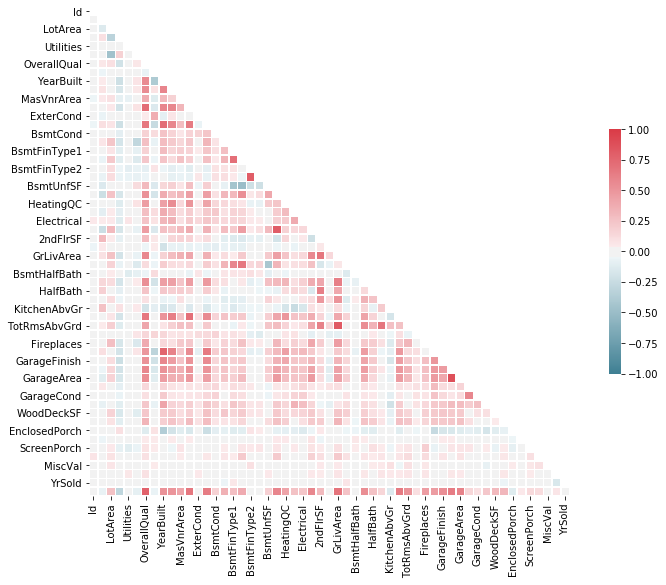

In [17]:
corr = train.corr()
display(corr)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Interesting. There's a lot more to consider here, but for now let's just focus on numerical features that are highly correlated with our target value.  

Yes, this is a gross simplification. But we'll do multivariate analysis later. I promise!!

In [18]:
display(corr['SalePrice'].sort_values())

LotShape        -0.293075
KitchenAbvGr    -0.136907
EnclosedPorch   -0.122351
LandSlope       -0.079142
MSSubClass      -0.066959
OverallCond     -0.055249
LowQualFinSF    -0.030450
BsmtFinType2    -0.030228
Id              -0.028558
BsmtHalfBath    -0.027794
MiscVal         -0.005600
YrSold          -0.002834
BsmtFinSF2       0.002782
Utilities        0.015742
ExterCond        0.035420
3SsnPorch        0.052563
MoSold           0.068958
GarageCond       0.100916
Functional       0.108502
PoolArea         0.123400
ScreenPorch      0.127997
BedroomAbvGr     0.152156
GarageQual       0.155196
BsmtCond         0.178312
BsmtUnfSF        0.187187
PavedDrive       0.230581
Electrical       0.242167
BsmtFullBath     0.252245
HalfBath         0.261258
CentralAir       0.261273
LotArea          0.262133
BsmtFinType1     0.277389
2ndFlrSF         0.297489
WoodDeckSF       0.309941
OpenPorchSF      0.313966
BsmtExposure     0.354426
BsmtFinSF1       0.384828
MasVnrArea       0.420529
HeatingQC   

Let's limit our model to just correlation coefficients .5 or above. That will bring us down to 14 numerical features.

In [19]:
corr_sp = corr['SalePrice']

print('')
columns_to_drop2 = corr_sp.loc[corr_sp < .5].index
display(columns_to_drop2)

train.drop(columns_to_drop2, inplace = True, axis = 1)
valid.drop(columns_to_drop2, inplace = True, axis = 1)
test.drop(columns_to_drop2, inplace = True, axis = 1)

Index(['Id', 'MSSubClass', 'LotArea', 'LotShape', 'Utilities', 'LandSlope',
       'OverallCond', 'MasVnrArea', 'ExterCond', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'HeatingQC', 'CentralAir', 'Electrical', '2ndFlrSF', 'LowQualFinSF',
       'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'Functional', 'Fireplaces', 'GarageYrBlt', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Now, we need to do some feature scaling!! Normalize this stuff.

For this, and later steps, we'll need to split out our X and y values.

We'll need to reverse transform our predictions before the end, so let's not forget that.

In [20]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]

X_valid = valid.iloc[:, :-1]
y_valid = valid.iloc[:, -1]

X_test = test

Ok, now we can scale the data. As always, only fit the the scaler on the TRAIN data, to prevent leakage.

Also, we have to do some reshaping to scale the y values.

Ok, having some trouble with scaling the data. Can't scale the y values for some reason.

I'll work on that later.

In [21]:
# X_scaler = StandardScaler()
# y_scaler = StandardScaler()
# X_scaler.fit(X_train)
# y_scaler.fit(y_train.reshape(-1, 1))

# X_train = X_scaler.transform(X_train)
# X_valid = X_scaler.transform(X_valid)
# X_test = X_scaler.transform(X_test)

# y_train = np.squeeze(y_scaler.transform(y_train.reshape(-1, 1)))
# y_valid = np.squeeze(y_scaler.transform(y_valid.reshape(-1, 1)))

# Training The Model

Now that we're down to a manageable number of features, let's start training and comparing models. We'll start with decision tree, random forest, XGBoost, and LightGBM.

## Decision Tree

In [22]:
model1 = DecisionTreeRegressor()
model1.fit(X_train, y_train)

valid_pred1 = model1.predict(X_valid)
error1 = np.sqrt(mse(valid_pred1, y_valid))
display(f'RMSE for model1 is ${error1}')

'RMSE for model1 is $42476.83054144632'

Well, I guess this isn't the worst, but given that the average sale price is 181286.518836, we're looking at about 20% error on average.

Ok, let's upload to Kaggle and compare:

In [23]:
test_pred1 = model1.predict(X_test)

output1 = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred1})

output1.to_csv(r'D:/code/Data/advanced_housing_submissions/advhousesub1.csv',index=False, header =1)

model1 got a score of 0.23263, which is substantially worse than our current best of 0.13284  

Our best came from XGBoost and the same procedure as the Kaggle tutorials, plus lots of hyperparameter tuning.

## Random Forest

Everyone knows random forest is way better than simple decision tree!!! Let's put that to the test.

In [24]:
model2 = RandomForestRegressor()
model2.fit(X_train, y_train)

valid_pred2 = model2.predict(X_valid)
error2 = np.sqrt(mse(valid_pred2, y_valid))
display(f'RMSE for model2 is ${error2}')

'RMSE for model2 is $30594.078968508893'

Alright, so far we're definitely beating Decision Tree. Let's also sumbit to Kaggle to see how we're doing.

In [25]:
test_pred2 = model2.predict(X_test)

output2 = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred2})

output2.to_csv(r'D:/code/Data/advanced_housing_submissions/advhousesub2.csv',index=False, header =1)

model2 got a score of 0.16133, which is a SUBSTANTIAL improvement over the decision tree. However, it's still a bit worse than our current best of 0.13284  

Our best came from XGBoost and the same procedure as the Kaggle tutorials, plus lots of hyperparameter tuning.


## XGBoost

XGBoost was the hottest model a few years ago. However, it's said to have been surpased by LightGBM these days. Let's find out!!!

Apparently XGBoost is dead on Anaconda. I can't install it. Vive la LightGBM!!!

## LightGBM

Let's test the new hotness.

In [26]:
model4 = lgb.LGBMRegressor()
model4.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=20, verbose = False)



valid_pred4 = model4.predict(X_valid)
error4 = np.sqrt(mse(valid_pred4, y_valid))

print('')

display(f'RMSE for model4 is ${error4}')

'RMSE for model4 is $33389.46222763908'

Yay, even better than decision tree. Let's also sumbit to Kaggle to see how we're doing.

In [27]:
test_pred4 = model4.predict(X_test)

output4 = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred4})

output4.to_csv(r'D:/code/Data/advanced_housing_submissions/advhousesub4.csv',index=False, header =1)

model4 got a score of 0.16308, which is slightly worse than decision tree. It's also still a bit worse than our current best of 0.13284  

Our best came from XGBoost and the same procedure as the Kaggle tutorials, plus lots of hyperparameter tuning.

We could likely improve with some hyperparameter tuning, but there are some other big picture improvements we could work on, like:

1.  k-fold validation
2.  Better feature generation and selection
3.  Then maybe some hyperparameter tuning

# LightGBM Big Dump

We've done about all we can with my first preprocessing attempt. Let's see how LightGBM does with minimal preprocessing. Just let it decide what to do. I'm going to call this model the "Big Dump" model, because we're basically just dumping everything into LightGBM and letting it figure out the answer.

In [28]:
housing1 = pd.read_csv('D:/code/Data/house-prices-advanced-regression-techniques/train.csv')
test1 = pd.read_csv('D:/code/Data/house-prices-advanced-regression-techniques/test.csv')

train1, valid1 = train_test_split(housing1, test_size = .2)

In [29]:
# Ok, ordinal encoder doesn't work with NaN values. Crap. Let's do the missing value thing from above first

# Drop heavily empty columns
columns_to_drop = train1.columns[train1.isnull().sum() > len(train1) * .15]
train1.drop(columns_to_drop, inplace = True, axis = 1)
valid1.drop(columns_to_drop, inplace = True, axis = 1)
test1.drop(columns_to_drop, inplace = True, axis = 1)


# Also, drop the IDs
train1.drop('Id', inplace = True, axis = 1)
valid1.drop('Id', inplace = True, axis = 1)
test1.drop('Id', inplace = True, axis = 1)


# Impute the rest

num_columns = train1.select_dtypes(exclude=['object']).columns
cat_columns = train1.select_dtypes(include=['object']).columns

# Impute Categorical Values
train1.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(train1.loc[:, cat_columns])
valid1.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(valid1.loc[:, cat_columns])
test1.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(test1.loc[:, cat_columns])

# Impute Numerical Values
train1.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(train1.loc[:, num_columns])
valid1.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(valid1.loc[:, num_columns])
test1.loc[:, num_columns.drop('SalePrice')] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(test1.loc[:, num_columns.drop('SalePrice')])

C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [30]:
#LightGBM says it can handle categorical features without the need for integer or one-hot, but it wasn't doing it for me. Piece of trash.
# LightGBM is supposed to do well with integer encoding, so let's try that
# Was having trouble, so I encoded each seperately, when I really should only encode based on the train data

code1 = OrdinalEncoder()

train1.loc[:, cat_columns] = code1.fit_transform(train1.loc[:, cat_columns])
valid1.loc[:, cat_columns] = code1.fit_transform(valid1.loc[:, cat_columns])
test1.loc[:, cat_columns] = code1.fit_transform(test1.loc[:, cat_columns])

C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Ok, now let's try 

In [31]:
X_train1 = train1.iloc[:, :-1]
y_train1 = train1.iloc[:, -1]

X_valid1 = valid1.iloc[:, :-1]
y_valid1 = valid1.iloc[:, -1]

X_test1 = test1

In [32]:
display(X_train1)
display(X_valid1)
display(X_test1)

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
788,20.0,4.0,6000.0,1.0,3.0,3.0,0.0,0.0,0.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2008.0,8.0,4.0
973,20.0,1.0,11639.0,1.0,3.0,3.0,0.0,0.0,0.0,21.0,...,120.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,6.0,5.0
630,70.0,4.0,9000.0,1.0,3.0,3.0,0.0,0.0,0.0,17.0,...,0.0,293.0,0.0,0.0,0.0,0.0,6.0,2006.0,8.0,0.0
518,60.0,3.0,9531.0,1.0,0.0,3.0,0.0,1.0,0.0,5.0,...,36.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,8.0,4.0
753,60.0,3.0,10240.0,1.0,3.0,3.0,0.0,4.0,0.0,16.0,...,52.0,0.0,0.0,0.0,0.0,0.0,3.0,2006.0,8.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,60.0,3.0,8924.0,1.0,0.0,3.0,0.0,1.0,0.0,5.0,...,155.0,0.0,0.0,0.0,0.0,0.0,7.0,2008.0,8.0,4.0
31,20.0,3.0,8544.0,1.0,0.0,3.0,0.0,1.0,0.0,19.0,...,65.0,0.0,0.0,0.0,0.0,0.0,6.0,2008.0,8.0,4.0
1008,20.0,3.0,12118.0,1.0,0.0,3.0,0.0,1.0,0.0,11.0,...,48.0,0.0,0.0,180.0,0.0,0.0,4.0,2009.0,8.0,4.0
686,60.0,1.0,10207.0,1.0,3.0,3.0,0.0,4.0,0.0,21.0,...,105.0,0.0,0.0,0.0,0.0,0.0,8.0,2007.0,6.0,5.0


,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
88,50.0,0.0,8470.0,1.0,0.0,3.0,0.0,0.0,0.0,8.0,...,0.0,156.0,0.0,0.0,0.0,0.0,10.0,2009.0,2.0,0.0
125,190.0,4.0,6780.0,1.0,3.0,3.0,0.0,3.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2006.0,4.0,4.0
872,20.0,3.0,8892.0,1.0,3.0,3.0,0.0,0.0,0.0,11.0,...,0.0,150.0,0.0,0.0,0.0,0.0,10.0,2008.0,4.0,4.0
52,90.0,4.0,8472.0,0.0,1.0,0.0,0.0,0.0,1.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2010.0,4.0,4.0
575,50.0,3.0,8480.0,1.0,3.0,3.0,0.0,3.0,0.0,11.0,...,0.0,102.0,0.0,0.0,0.0,0.0,10.0,2008.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,75.0,3.0,8400.0,1.0,3.0,0.0,0.0,3.0,1.0,17.0,...,24.0,0.0,0.0,0.0,0.0,0.0,7.0,2008.0,4.0,4.0
521,20.0,3.0,11988.0,1.0,0.0,3.0,0.0,0.0,0.0,11.0,...,40.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,4.0,4.0
1266,190.0,4.0,10120.0,1.0,0.0,0.0,0.0,3.0,0.0,16.0,...,0.0,264.0,0.0,0.0,0.0,0.0,1.0,2007.0,4.0,4.0
173,20.0,3.0,10197.0,1.0,0.0,3.0,0.0,3.0,0.0,11.0,...,20.0,0.0,0.0,0.0,0.0,0.0,6.0,2008.0,0.0,4.0


,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20.0,2.0,11622.0,1.0,3.0,3.0,0.0,4.0,0.0,12.0,...,0.0,0.0,0.0,120.0,0.0,0.0,6.0,2010.0,8.0,4.0
1,20.0,3.0,14267.0,1.0,0.0,3.0,0.0,0.0,0.0,12.0,...,36.0,0.0,0.0,0.0,0.0,12500.0,6.0,2010.0,8.0,4.0
2,60.0,3.0,13830.0,1.0,0.0,3.0,0.0,4.0,0.0,8.0,...,34.0,0.0,0.0,0.0,0.0,0.0,3.0,2010.0,8.0,4.0
3,60.0,3.0,9978.0,1.0,0.0,3.0,0.0,4.0,0.0,8.0,...,36.0,0.0,0.0,0.0,0.0,0.0,6.0,2010.0,8.0,4.0
4,120.0,3.0,5005.0,1.0,0.0,1.0,0.0,4.0,0.0,22.0,...,82.0,0.0,0.0,144.0,0.0,0.0,1.0,2010.0,8.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160.0,4.0,1936.0,1.0,3.0,3.0,0.0,4.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2006.0,8.0,4.0
1455,160.0,4.0,1894.0,1.0,3.0,3.0,0.0,4.0,0.0,10.0,...,24.0,0.0,0.0,0.0,0.0,0.0,4.0,2006.0,8.0,0.0
1456,20.0,3.0,20000.0,1.0,3.0,3.0,0.0,4.0,0.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,2006.0,8.0,0.0
1457,85.0,3.0,10441.0,1.0,3.0,3.0,0.0,4.0,0.0,11.0,...,32.0,0.0,0.0,0.0,0.0,700.0,7.0,2006.0,8.0,4.0


In [33]:
model5 = lgb.LGBMRegressor()
model5.fit(X_train1, y_train1,
            eval_set=[(X_valid1, y_valid1)],
            early_stopping_rounds=20, verbose = False)

valid_pred5 = model5.predict(X_valid1)
error5 = np.sqrt(mse(valid_pred5, y_valid1))

print('')

display(f'RMSE for model5 is ${error5}')

'RMSE for model5 is $32370.648180106335'

Well, I've run this a few times, and it keeps changing. Let's kaggle it and see how we do.

In [34]:
test_pred5 = model5.predict(X_test1)

output5 = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred5})

output5.to_csv(r'D:/code/Data/advanced_housing_submissions/advhousesub5.csv',index=False, header =1)

Kaggle: .14081
    
Well crap, this is better than even my attempt with all the encoding and stuff. What a waste of time!

Let's try tuning this bad boy.

## Grid Search the Big Dump Model

In [35]:
param_test = {'num_leaves': range(50, 60), 
             'learning_rate': [.1],
#              'min_child_samples': range(100, 500), 
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': (.2, .3, .4, .5, .6, .7, .8), 
#              'colsample_bytree': (.2, .3, .4, .5, .6),
#              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
            }



model7 = lgb.LGBMRegressor(max_depth=-1, silent=True, n_jobs=4, n_estimators=5000, verbose = -1)



gs = gscv(
            estimator=model7, 
            param_grid=param_test, 
            scoring='neg_root_mean_squared_error',
            #cv=5,
            refit=True,
            verbose=True
            )

gs.fit(X_train1, y_train1, eval_set = [(X_valid1, y_valid1)], eval_metric = 'rmse', verbose = False, early_stopping_rounds = 30)
print(f'Best score reached: {gs.best_score_} with params: {gs.best_params_} ')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.9min finished


Best score reached: -30438.482169675262 with params: {'learning_rate': 0.1, 'num_leaves': 50} 


In [36]:
model8 = lgb.LGBMRegressor(**gs.best_params_)
model8.fit(X_train1, y_train1, eval_set=[(X_valid1, y_valid1)], early_stopping_rounds=30, verbose = False)

valid_pred8 = model8.predict(X_valid1)
error8 = np.sqrt(mse(valid_pred8, y_valid1))

print('')

display(f'RMSE for model8 with parameters {gs.best_params_} is ${error8}')

"RMSE for model8 with parameters {'learning_rate': 0.1, 'num_leaves': 50} is $32248.08729985461"

List of things that performed decently:  

1. learning_rate = .1, num_leaves = 9, early_stopping_rounds = 30, RMSE for model8 is 19088.782686261766'
2. {'early_stopping_rounds': 100, 'learning_rate': 0.01, 'num_leaves': 11}, 'RMSE for model8 is 19088.782686261766'
3. {'learning_rate': 0.01, 'num_leaves': 6, early_stopping rounds = 50}, 'RMSE for model8 is 36324.154902046415'










In [37]:
test_pred8 = model8.predict(X_test1)

output8 = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred8})

output8.to_csv(r'D:/code/Data/advanced_housing_submissions/advhousesub8.csv',index=False, header =1)

2. Kaggle: .14039
A little better, still not beating our og. Let's go nuts with hyper tuning.

3. 

Ok, this did eventually give us a decent result, but it's SLOW AS HECK to grid search, and I'm getting bored. Let's RANDOM SEARCH BABY!!!

## Random Search the Big Dump Model

In [55]:
param_test = {'num_leaves': range(2, 20), 
             'learning_rate': [.01, .02, .03, .04, .05, .06, .07, .08, .09, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
              'early_stopping_rounds' : range(10, 200, 10)
#              'min_child_samples': range(100, 500), 
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': (.2, .3, .4, .5, .6, .7, .8), 
#              'colsample_bytree': (.2, .3, .4, .5, .6),
#              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
            }



model9 = lgb.LGBMRegressor(max_depth=-1, silent=True, n_jobs=4, n_estimators=5000, verbose = -1)



rs = rscv(
            estimator=model9, 
            param_distributions=param_test, 
            scoring='neg_root_mean_squared_error',
            cv=5,
            refit=True,
            verbose=True,
            n_iter = 100
            )

rs.fit(X_train1, y_train1, eval_set = [(X_valid1, y_valid1)], eval_metric = 'rmse', verbose = False)

print(f'Best score reached: {rs.best_score_} with params: {rs.best_params_} ')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\evant\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\evant\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\evant\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\evant\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will us

Best score reached: -28313.014193029318 with params: {'num_leaves': 3, 'learning_rate': 0.06, 'early_stopping_rounds': 40} 


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.7min finished
C:\Users\evant\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [56]:
model9 = lgb.LGBMRegressor(**rs.best_params_)
model9.fit(X_train1, y_train1, eval_set=[(X_valid1, y_valid1)], verbose = False)

valid_pred9 = model9.predict(X_valid1)
error9 = np.sqrt(mse(valid_pred9, y_valid1))

print('')

display(f'RMSE for model9 with parameters {rs.best_params_} is ${error9}')

"RMSE for model9 with parameters {'num_leaves': 3, 'learning_rate': 0.06, 'early_stopping_rounds': 40} is $36486.701188774045"

List of things that performed decently:  

1. "RMSE for model9 with parameters {'num_leaves': 10, 'learning_rate': 0.02, 'early_stopping_rounds': 180} is 36890.537657012734"
2. "RMSE for model9 with parameters {'num_leaves': 11, 'learning_rate': 0.01, 'early_stopping_rounds': 30} is 47800.831296522185"
3. "RMSE for model9 with parameters {'num_leaves': 8, 'learning_rate': 0.02, 'early_stopping_rounds': 30} is 38031.55374833302"
4. "RMSE for model9 with parameters {'num_leaves': 8, 'learning_rate': 0.2, 'early_stopping_rounds': 10} is 28506.639199674595"
5. "RMSE for model9 with parameters {'num_leaves': 14, 'learning_rate': 0.1, 'early_stopping_rounds': 10} is 28387.987302916474"
6. "RMSE for model9 with parameters {'num_leaves': 15, 'learning_rate': 0.1, 'early_stopping_rounds': 10} is 28320.97315991774
7. "RMSE for model9 with parameters {'num_leaves': 3, 'learning_rate': 0.06, 'early_stopping_rounds': 40} is 36486.701188774045"


In [40]:
test_pred9 = model9.predict(X_test1)

output9 = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred9})

output9.to_csv(r'D:/code/Data/advanced_housing_submissions/advhousesub9.csv',index=False, header =1)

In [41]:
model8 = lgb.LGBMRegressor(learning_rate = .01, num_leaves = 50)
model8.fit(X_train1, y_train1, eval_set=[(X_valid1, y_valid1)], early_stopping_rounds=30, verbose = False)

valid_pred8 = model8.predict(X_valid1)
error8 = np.sqrt(mse(valid_pred8, y_valid1))

print('')

display(f'RMSE for model8 is ${error8}')

'RMSE for model8 is $49734.67370821238'

List of things that performed decently:  

1. learning_rate = .1, num_leaves = 9, early_stopping_rounds = 30, RMSE for model8 is 19088.782686261766'
2. {'early_stopping_rounds': 100, 'learning_rate': 0.01, 'num_leaves': 11}, 'RMSE for model8 is 19088.782686261766'
3. {'learning_rate': 0.01, 'num_leaves': 6, early_stopping rounds = 50}, 'RMSE for model8 is 36324.154902046415'










In [42]:
test_pred8 = model8.predict(X_test1)

output8 = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred8})

output8.to_csv(r'D:/code/Data/advanced_housing_submissions/advhousesub8.csv',index=False, header =1)

2. Kaggle: .14039
A little better, still not beating our og. Let's go nuts with hyper tuning.

3. 

1. Kaggle:

# Reprocessing the Data

Let's try some other ways of preprocessing the data.

## Keep everything but very empty columns, use my encoding where possible, otherwise use integer encoding.

In [43]:
housing2 = pd.read_csv('D:/code/Data/house-prices-advanced-regression-techniques/train.csv')
test2 = pd.read_csv('D:/code/Data/house-prices-advanced-regression-techniques/test.csv')

train2, valid2 = train_test_split(housing2, test_size = .2)

columns_to_drop2 = train2.columns[train2.isnull().sum() > len(train2) * .15]
train2.drop(columns_to_drop2, inplace = True, axis = 1)
valid2.drop(columns_to_drop2, inplace = True, axis = 1)
test2.drop(columns_to_drop2, inplace = True, axis = 1)

num_columns2 = train2.select_dtypes(exclude=['object']).columns
cat_columns2 = train2.select_dtypes(include=['object']).columns

# Impute Categorical Values
train2.loc[:, cat_columns2] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(train2.loc[:, cat_columns2])
valid2.loc[:, cat_columns2] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(valid2.loc[:, cat_columns2])
test2.loc[:, cat_columns2] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(test2.loc[:, cat_columns2])

# Impute Numerical Values
train2.loc[:, num_columns2] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(train2.loc[:, num_columns2])
valid2.loc[:, num_columns2] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(valid2.loc[:, num_columns2])
test2.loc[:, num_columns2.drop('SalePrice')] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(test2.loc[:, num_columns2.drop('SalePrice')])

lotshape_map = {'Reg':3, 'IR1':2, 'IR2':1, 'IR2':0}
utilities_map = {'AllPub':3, 'NoSewr':2, 'NoSeWa':1, 'ELO':0}
landslope_map = {'Gtl':2, 'Mod':1, 'Sev':0}
exterqual_map = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0}
extercond_map = exterqual_map
bsmtqual_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
bsmtcond_map = bsmtqual_map
bsmtexposure_map = {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0}
bsmtfintype1_map = {'GLQ':5, 'ALQ':4, 'BLQ':3, 'Rec':4, 'LwQ':2, 'Unf':1, 'NA':0}
bsmtfintype2_map = bsmtfintype1_map
heatingqc_map = exterqual_map
centralair_map = {'Y':1, 'N':0}
electrical_map = {'SBrkr':3, 'FuseA':2, 'FuseF':1, 'FuseP':0}
kitchenqual_map = exterqual_map
functional_map = {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0}
garagefinish_map = {'Fin':3, 'RFn':2, 'Unf':1, 'NA':0}
garagequal_map = bsmtqual_map
garagecond_map = bsmtqual_map
paveddrive_map = {'Y':2, 'P':1, 'N':0}

ordinal_maps = [lotshape_map, utilities_map, landslope_map, exterqual_map, extercond_map, bsmtqual_map, bsmtcond_map, bsmtexposure_map, bsmtfintype1_map, bsmtfintype2_map, heatingqc_map, centralair_map, electrical_map, kitchenqual_map, functional_map, garagefinish_map, garagequal_map, garagecond_map, paveddrive_map]
ordinal_features = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive']

for i in range(len(ordinal_maps)):
    train2[ordinal_features[i]] = train2[ordinal_features[i]].map(ordinal_maps[i])
    valid2[ordinal_features[i]] = valid2[ordinal_features[i]].map(ordinal_maps[i])
    test2[ordinal_features[i]] = test2[ordinal_features[i]].map(ordinal_maps[i])

cat_columns2 = train2.select_dtypes(include=['object']).columns

C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [44]:
# #Ok, now let's one-hot these fools!
# train2 = pd.get_dummies(train2)
# valid2 = pd.get_dummies(valid2)
# test2 = pd.get_dummies(test2)

code2 = OrdinalEncoder()

train2.loc[:, cat_columns2] = code2.fit_transform(train2.loc[:, cat_columns2])
valid2.loc[:, cat_columns2] = code2.fit_transform(valid2.loc[:, cat_columns2])
test2.loc[:, cat_columns2] = code2.fit_transform(test2.loc[:, cat_columns2])

C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Ok, let's train!!!

In [45]:
X_train2 = train2.iloc[:, :-1]
y_train2 = train2.iloc[:, -1]

X_valid2 = valid2.iloc[:, :-1]
y_valid2 = valid2.iloc[:, -1]

X_test2 = test2

model6 = lgb.LGBMRegressor()
model6.fit(X_train2, y_train2,
            eval_set=[(X_valid2, y_valid2)],
            early_stopping_rounds=20, verbose = False)

valid_pred6 = model6.predict(X_valid2)
error6 = np.sqrt(mse(valid_pred6, y_valid2))

print('')

display(f'RMSE for model5 is ${error6}')

'RMSE for model5 is $26170.30656093021'

Holy crap!!! We're down to 22915!!! That's Way freaking better than anything else so far!!!  

Damn, I'm good.  

Let's see how it perform on Kaggle.

In [46]:
test_pred6 = model6.predict(X_test2)

output6 = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred6})

output6.to_csv(r'D:/code/Data/advanced_housing_submissions/advhousesub6.csv',index=False, header =1)

Crap! Still not an improvement on Kaggle, though better than anything else we've tried in this kernal.

Kaggle: 0.14104
    
Probably still comes down to preprocessing, but let's try a little hyp tuning and see what we can do. We could also do cross - validation. Oh, and I still need to normalize the data.

## Random Search my Preprocessing

Note that a lot of this is taken from an excellent Kaggle kernal. Hopefully I'll be able to dive into each of these features and understand them more in time.

https://www.kaggle.com/mlisovyi/lightgbm-hyperparameter-optimisation-lb-0-761#Model-fitting-with-HyperParameter-optimisation

In [50]:
param_test = {'num_leaves': range(2, 20), 
             'learning_rate': [.01, .02, .03, .04, .05, .06, .07, .08, .09, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
              'early_stopping_rounds' : range(10, 50, 10)
#              'min_child_samples': range(100, 500), 
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': (.2, .3, .4, .5, .6, .7, .8), 
#              'colsample_bytree': (.2, .3, .4, .5, .6),
#              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
            }



model7 = lgb.LGBMRegressor(max_depth=-1, silent=True, n_jobs=4, n_estimators=5000, verbose = -1)



rs = rscv(
            estimator=model7, 
            param_distributions=param_test, 
            scoring='neg_root_mean_squared_error',
            cv=5,
            refit=True,
            verbose=True,
            n_iter = 100
            )

rs.fit(X_train2, y_train2, eval_set = [(X_valid2, y_valid2)], eval_metric = 'rmse', verbose = False)

print(f'Best score reached: {rs.best_score_} with params: {rs.best_params_} ')

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\evant\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\evant\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\evant\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\evant\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will us

Best score reached: -28671.994033819887 with params: {'num_leaves': 14, 'learning_rate': 0.09, 'early_stopping_rounds': 10} 


In [51]:
model7 = lgb.LGBMRegressor(**rs.best_params_)
model7.fit(X_train2, y_train2, eval_set=[(X_valid2, y_valid2)], verbose = False)

valid_pred7 = model7.predict(X_valid2)
error7 = np.sqrt(mse(valid_pred7, y_valid2))

print('')

display(f'RMSE for model7 with parameters {rs.best_params_} is ${error7}')

"RMSE for model7 with parameters {'num_leaves': 14, 'learning_rate': 0.09, 'early_stopping_rounds': 10} is $25543.225120857005"

List of things that performed decently:  

1. "RMSE for model7 with parameters {'num_leaves': 7, 'learning_rate': 0.1, 'early_stopping_rounds': 30} is 26200.168821416515"
2. "RMSE for model7 with parameters {'num_leaves': 12, 'learning_rate': 0.3, 'early_stopping_rounds': 40} is 35874.30209147329"
3. "RMSE for model7 with parameters {'num_leaves': 9, 'learning_rate': 0.02, 'early_stopping_rounds': 40} is 27146.89532722071"
4. "RMSE for model7 with parameters {'num_leaves': 18, 'learning_rate': 0.08, 'early_stopping_rounds': 40} is 24956.638132730524"


In [49]:
test_pred7 = model7.predict(X_test2)

output7 = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred7})

output7.to_csv(r'D:/code/Data/advanced_housing_submissions/advhousesub7.csv',index=False, header =1)

1. Kaggle: 

2. 

# Conclusion

Well, we've had a lot of fun, but what have we learned?  
1. 

## Future Research

I'm ready to move on to other research and other datasets, but what would I do if I were to continue with this dataset?  

1. Develope pipelines for all of my procedures. sklearn has some cool built in functions for creating pipelines.
2. Use dimensionality reduction to try to look for the most important features / linear combinations of features.
3. Use L1 / Lasso to select features
4. Ask LightGBM what the most important features were.